# dmarketing.ai

### Deep Learning

### Project: Build a reviews' classifier based on Amazon's reviews dataset

<font color=red>__*Provide project's description here*__</font>

### Step 0: Load The Data 

In [1]:
import os

DATA_FOLDER_PATH = "./data"
TRAIN_DATA_PATH = os.path.join(DATA_FOLDER_PATH, 'train.csv')
TEST_DATA_PATH = os.path.join(DATA_FOLDER_PATH, 'test.csv')

In [2]:
def count_samples(csv_file_path):
    samples_cnt = 0

    with open(csv_file_path, 'r', errors='ignore') as csv_file:
        for lines in csv_file:
            samples_cnt += 1
    return samples_cnt

In [3]:
train_samples = count_samples(TRAIN_DATA_PATH)
test_samples = count_samples(TEST_DATA_PATH)

In [4]:
print("Number of train samples : {}\nNumber of test samples : {}".format(train_samples, test_samples))

Number of train samples : 3000000
Number of test samples : 650000


In [5]:
import csv, string

RATING_IDX = 0
TITLE_IDX = 1
REVIEW_IDX = 2

def flow_from_csv(path=None, col_idx=REVIEW_IDX):
    '''Produces generator that iterates through col_idxes in csv file containg data.
                
            Parameters:
            path (str): file system path to a csv file with data samples.
            loc_idx(int): number of column.
                
            Returns:
            generator: generator that returns data from each row specified by col_idx.
     '''
    with open(path, 'r', errors='ignore') as csv_file:
        reader = csv.reader(csv_file)
        
        readed_cnt = 0
        while readed_cnt != train_samples - 1:
            row = next(reader)
            
            text = row[col_idx].lower()
            text = text.translate(str.maketrans('', '', string.punctuation))
            
            readed_cnt += 1
            yield text
            
    return

### Step 1: Dataset Summary & Explonation

<font color=red>__*Feature descriptions*__</font>

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
review_gen = flow_from_csv(TRAIN_DATA_PATH, REVIEW_IDX)

tokenizer.fit_on_texts(review_gen)

<BarContainer object of 30 artists>

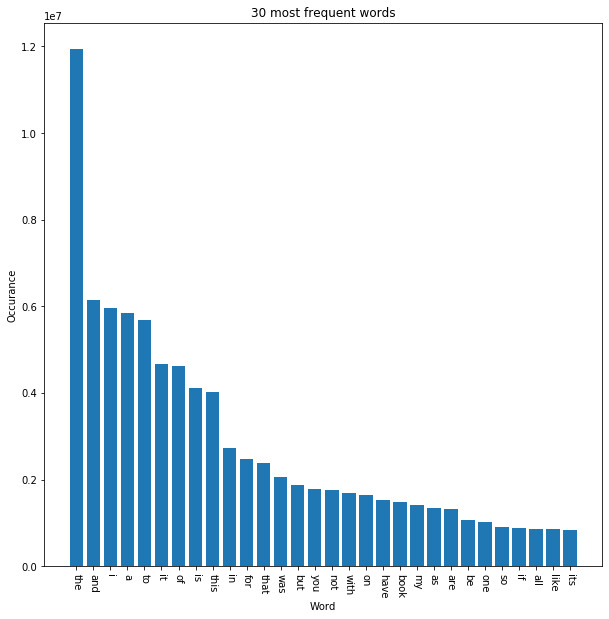

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

word_cnt = tokenizer.word_counts

# Extracts the most frequent words
most_freq_words = 30

sorted_items = list(word_cnt.items())
sorted_items.sort(key=lambda item: item[-1], reverse=True)

most_freq_keys = [k for k, v in sorted_items[:most_freq_words]]
most_freq_values = [v for k, v in sorted_items[:most_freq_words]]

# Draws bar char of most frequent words
plt.figure(figsize=(10, 10))
plt.title(str(most_freq_words) + " most frequent words")
plt.xlabel("Word")
plt.xticks(rotation=-90)
plt.ylabel("Occurance")
plt.bar(most_freq_keys, most_freq_values)

### Step 2: Design and Validate a Model Architecture 

<font color=red>__*Neural Net architecture descriptions tested*__</font>

In [30]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_pipeline(path, maxlen, batch_size=1, start_idx=0):
    '''Produces generator that will be used to train neural network.

            Parameters:
            path (str): file system path to a csv file with data samples.

            Returns:
            generator: generator that returns tuple(list_of_reviews, list_of_outputs).
    '''
    with open(path, 'r', errors='ignore') as csv_file:
        reader = csv.reader(csv_file)

        readed_cnt = 0
        # Skip first start_idx rows
        while readed_cnt != start_idx:
            next(reader)
            readed_cnt += 1;

        while readed_cnt + batch_size <= train_samples - 1:
            reviews = []
            ratings = []

            for _ in range(batch_size):
                row = next(reader)
                # Extract ratings
                rating = row[RATING_IDX]
                ratings.append(ord(rating) - ord('0'))

                # Extract and clear reviews
                review = row[REVIEW_IDX].lower()
                review = review.translate(str.maketrans('', '', string.punctuation))
                reviews.append(review)

                readed_cnt += 1

            # Tokenize and pad sequences
            reviews = tokenizer.texts_to_sequences(reviews)
            reviews = pad_sequences(reviews, maxlen=maxlen)

            # Converting input to binary class matrix
            ratings = to_categorical(ratings, num_classes=6, dtype='uint8')
            ratings = np.delete(ratings, 0, axis=1)
            
            yield reviews, ratings, [None]

    return

In [70]:
max_len = 100    # Maximal length of a sequence that can be feed to neural network

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(max_words, 256, input_length=max_len),
    tf.keras.layers.LSTM(128, recurrent_dropout=0.2, dropout=0.2),
    tf.keras.layers.Dense(5, activation='softmax')
])
optimizer = tf.keras.optimizers.RMSprop(lr=0.01)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [71]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 256)          2560000   
_________________________________________________________________
lstm_13 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 645       
Total params: 2,757,765
Trainable params: 2,757,765
Non-trainable params: 0
_________________________________________________________________


In [72]:
data_gen = data_pipeline(TRAIN_DATA_PATH, maxlen=max_len, batch_size=128)
val_gen = data_pipeline(TRAIN_DATA_PATH, maxlen=max_len, batch_size=128, start_idx=2 * 10^6)

history = model.fit(data_gen, steps_per_epoch=100,
                              epochs=25, 
                              validation_data=val_gen,
                              validation_steps=50)

Train for 100 steps, validate for 50 steps
Epoch 1/25
100/100 [==============================] - 28s 282ms/step - loss: 1.4976 - acc: 0.3291 - val_loss: 1.2675 - val_acc: 0.4770
Epoch 2/25
100/100 [==============================] - 27s 267ms/step - loss: 1.3650 - acc: 0.3948 - val_loss: 1.2410 - val_acc: 0.4839
Epoch 3/25
100/100 [==============================] - 27s 269ms/step - loss: 1.3151 - acc: 0.4227 - val_loss: 1.2336 - val_acc: 0.4764
Epoch 4/25
100/100 [==============================] - 26s 265ms/step - loss: 1.3069 - acc: 0.4230 - val_loss: 1.2114 - val_acc: 0.4898
Epoch 5/25
100/100 [==============================] - 26s 265ms/step - loss: 1.2867 - acc: 0.4357 - val_loss: 1.2270 - val_acc: 0.4769
Epoch 6/25
100/100 [==============================] - 27s 268ms/step - loss: 1.2726 - acc: 0.4466 - val_loss: 1.1946 - val_acc: 0.4870
Epoch 7/25
100/100 [==============================] - 32s 317ms/step - loss: 1.2576 - acc: 0.4518 - val_loss: 1.1962 - val_acc: 0.4789
Epoch 8/25
1

In [12]:
# model.save('first.h5')

### Step 3: Test a Model on New Reviews

In [13]:
def test():
    pass

### Step 4: Summary

<font color=red>__*Final conclusions*__</font>